<a href="https://colab.research.google.com/github/sp7412/colab/blob/master/distilling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

In [1]:
!nvidia-smi

Thu Aug  6 03:06:53 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

def softmax_sparse_categorical_crossentropy(labels, logits):
  softmaxed = tf.keras.backend.softmax(logits)

  return tf.keras.losses.sparse_categorical_crossentropy(labels, softmaxed)

In [4]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.0. Subsequent calls will reuse this data.


In [5]:
num_classes = ds_info.features['label'].num_classes

In [6]:
ds_info.features['image'].shape

(28, 28, 1)

In [7]:
num_training_examples = ds_info.splits['train'].num_examples
num_training_examples

60000

In [8]:
ds_train_iter = ds_train.as_numpy_iterator()
train_images, train_labels = zip(*[ds_train_iter.next() for i in range(num_training_examples)])
train_images = np.asarray(train_images)

Text(0.5, 1.0, '4')

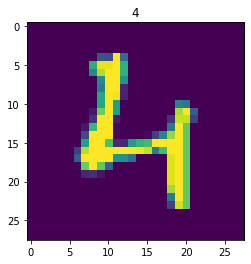

In [ ]:
import matplotlib.pyplot as plt
idx = 10
plt.imshow(np.squeeze(train_images[idx]))
plt.title(train_labels[idx])

9

In [ ]:
train_images.shape

(60000, 28, 28, 1)

In [9]:
num_testing_examples = ds_info.splits['test'].num_examples
num_testing_examples

10000

In [10]:
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [11]:
ds_test_iter = ds_test.as_numpy_iterator()

In [12]:
test_images, test_labels = zip(*[ds_test_iter.next() for i in range(num_testing_examples)])

In [13]:
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [14]:
control_model = tf.keras.models.Sequential([
  tf.keras.Input([28, 28]), 
  tf.keras.layers.Reshape([28, 28, 1]), 
  tf.keras.layers.Conv2D(64, 3, 2, activation='relu'), 
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(64, 3, 2, activation='relu'), 
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(), 
  tf.keras.layers.Dense(10, activation='softmax')])
  # tf.keras.layers.Dense(10, activation=None)])

control_model.compile('adam', 'sparse_categorical_crossentropy', ['accuracy'])
# control_model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
# control_model.compile('adam', softmax_sparse_categorical_crossentropy, ['accuracy'])
control_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 13, 13, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 13, 13, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 64)          36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 6, 6, 64)          256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 64)          0

In [15]:
control_model.fit(ds_train, epochs=10)

test_loss, test_acc = control_model.evaluate(ds_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

Epoch 1/10
469/469 [==============================] - 3s 7ms/step - loss: 0.9676 - accuracy: 0.7377
Epoch 2/10
469/469 [==============================] - 3s 7ms/step - loss: 0.3829 - accuracy: 0.9021
Epoch 3/10
469/469 [==============================] - 3s 7ms/step - loss: 0.2688 - accuracy: 0.9266
Epoch 4/10
469/469 [==============================] - 3s 7ms/step - loss: 0.2251 - accuracy: 0.9373
Epoch 5/10
469/469 [==============================] - 3s 7ms/step - loss: 0.1971 - accuracy: 0.9426
Epoch 6/10
469/469 [==============================] - 3s 7ms/step - loss: 0.1791 - accuracy: 0.9475
Epoch 7/10
469/469 [==============================] - 3s 7ms/step - loss: 0.1676 - accuracy: 0.9498
Epoch 8/10
469/469 [==============================] - 3s 7ms/step - loss: 0.1596 - accuracy: 0.9509
Epoch 9/10
469/469 [==============================] - 3s 7ms/step - loss: 0.1527 - accuracy: 0.9532
Epoch 10/10
79/79 [==============================] - 2s 30ms/step - loss: 0.1367 - accuracy: 0.9575


In [16]:
test_loss, test_acc = control_model.evaluate(ds_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

79/79 [==============================] - 0s 4ms/step - loss: 0.1367 - accuracy: 0.9575
Test Loss: 0.13672614097595215
Test Accuracy: 0.9574999809265137


In [17]:
test_loss, test_acc = control_model.evaluate(np.asarray(test_images,dtype=np.float64),
                                             np.asarray(test_labels,dtype=np.float64))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

313/313 [==============================] - 1s 3ms/step - loss: 0.1367 - accuracy: 0.9575
Test Loss: 0.13672615587711334
Test Accuracy: 0.9574999809265137


In [18]:
teacher_model = tf.keras.models.Sequential([
  tf.keras.Input([28, 28]), 
  tf.keras.layers.Reshape([28, 28, 1]), 
  tf.keras.layers.Conv2D(64, 3, 2, activation='relu'), 
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(64, 3, 2, activation='relu'), 
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(64, 3, 2, activation='relu'), 
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(), 
  #tf.keras.layers.Dense(10, activation='softmax')])
  tf.keras.layers.Dense(10, activation=None)])

#teacher_model.compile('adam', 'sparse_categorical_crossentropy', ['accuracy'])
teacher_model.compile('adam', softmax_sparse_categorical_crossentropy, ['accuracy'])
teacher_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        640       
_________________________________________________________________
batch_normalization_2 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 64)          36928     
_________________________________________________________________
batch_normalization_3 (Batch (None, 6, 6, 64)          256       
_________________________________________________________________
dropout_3 (Dropout)          (None, 6, 6, 64)         

In [19]:
teacher_model.fit(ds_train, epochs=15)

test_loss, test_acc = teacher_model.evaluate(ds_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

Epoch 1/15
469/469 [==============================] - 4s 8ms/step - loss: 0.3832 - accuracy: 0.8946
Epoch 2/15
469/469 [==============================] - 4s 8ms/step - loss: 0.1248 - accuracy: 0.9640
Epoch 3/15
469/469 [==============================] - 4s 8ms/step - loss: 0.0907 - accuracy: 0.9732
Epoch 4/15
469/469 [==============================] - 4s 8ms/step - loss: 0.0738 - accuracy: 0.9775
Epoch 5/15
469/469 [==============================] - 4s 8ms/step - loss: 0.0660 - accuracy: 0.9797
Epoch 6/15
469/469 [==============================] - 4s 9ms/step - loss: 0.0568 - accuracy: 0.9827
Epoch 7/15
469/469 [==============================] - 4s 8ms/step - loss: 0.0540 - accuracy: 0.9828
Epoch 8/15
469/469 [==============================] - 4s 8ms/step - loss: 0.0478 - accuracy: 0.9852
Epoch 9/15
469/469 [==============================] - 4s 8ms/step - loss: 0.0455 - accuracy: 0.9854
Epoch 10/15
469/469 [==============================] - 4s 8ms/step - loss: 0.0425 - accuracy: 0.9863

In [20]:
ds_train_images = tf.data.Dataset.from_tensor_slices(list(map(lambda x:tf.reshape(x,(-1,28,28,1)), train_images)))
soft_labels_train = teacher_model.predict(train_images,verbose=1)

1875/1875 [==============================] - 4s 2ms/step


In [ ]:
soft_labels_train

array([[-3.2132983 ,  3.491695  , -2.608758  , ...,  5.2562127 ,
        -4.3469596 , -2.0890887 ],
       [-0.8473589 , 13.893081  , -1.3238841 , ...,  4.725108  ,
        -3.106113  , -3.4589026 ],
       [17.102049  ,  0.50875515, -1.7520702 , ..., -2.4097998 ,
        -3.6546803 , -2.2963073 ],
       ...,
       [ 3.3898787 ,  2.807206  ,  1.3815862 , ..., -5.788686  ,
        -3.890337  , -3.9900806 ],
       [-0.44898036, 13.447332  , -3.491755  , ...,  0.706247  ,
        -3.2284858 , -1.0321379 ],
       [-7.4827347 , -3.6161199 , -3.7202818 , ..., -0.63771945,
         4.3963366 ,  1.0665143 ]], dtype=float32)

In [21]:
temperature = 3
afterwards_temperature = 1

def temperature_softmax(logits):
  soft_logits = tf.keras.backend.exp(logits / temperature)
  return soft_logits / tf.keras.backend.sum(soft_logits, axis=-1, keepdims=True) / afterwards_temperature

def distillation_loss(labels, logits):
  labels = temperature_softmax(labels)
  logits = temperature_softmax(logits)

  return -tf.keras.backend.mean(labels * tf.keras.backend.log(logits))

In [22]:
student_model = tf.keras.models.Sequential([
  tf.keras.Input([28, 28]), 
  tf.keras.layers.Reshape([28, 28, 1]), 
  tf.keras.layers.Conv2D(64, 3, 2, activation='relu'), 
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(64, 3, 2, activation='relu'), 
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(), 
  # tf.keras.layers.Dense(10, activation='softmax')])
  tf.keras.layers.Dense(10, activation=None)])

student_model.compile('adam', distillation_loss, ['accuracy'])
student_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 64)        640       
_________________________________________________________________
batch_normalization_5 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
dropout_5 (Dropout)          (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 6, 64)          36928     
_________________________________________________________________
batch_normalization_6 (Batch (None, 6, 6, 64)          256       
_________________________________________________________________
dropout_6 (Dropout)          (None, 6, 6, 64)         

In [23]:
student_model.fit(train_images, soft_labels_train, epochs=15, validation_split=0.2)

Epoch 1/15
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1201 - accuracy: 0.7428 - val_loss: 0.0770 - val_accuracy: 0.8978
Epoch 2/15
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0719 - accuracy: 0.9062 - val_loss: 0.0728 - val_accuracy: 0.8992
Epoch 3/15
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0663 - accuracy: 0.9255 - val_loss: 0.0618 - val_accuracy: 0.9465
Epoch 4/15
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0641 - accuracy: 0.9342 - val_loss: 0.0611 - val_accuracy: 0.9500
Epoch 5/15
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0629 - accuracy: 0.9400 - val_loss: 0.0611 - val_accuracy: 0.9462
Epoch 6/15
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0621 - accuracy: 0.9429 - val_loss: 0.0564 - val_accuracy: 0.9607
Epoch 7/15
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0616 - accuracy: 0.9447 - val_loss: 0.0570 - val_accuracy:

In [27]:
student_model.layers[-1].activation = tf.keras.activations.softmax

In [34]:
student_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [35]:
student_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 64)        640       
_________________________________________________________________
batch_normalization_5 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
dropout_5 (Dropout)          (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 6, 64)          36928     
_________________________________________________________________
batch_normalization_6 (Batch (None, 6, 6, 64)          256       
_________________________________________________________________
dropout_6 (Dropout)          (None, 6, 6, 64)         

In [36]:
test_loss, test_acc = student_model.evaluate(ds_test, batch_size=128)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

79/79 [==============================] - 0s 4ms/step - loss: 0.1107 - accuracy: 0.9673
Test Loss: 0.11067593097686768
Test Accuracy: 0.9672999978065491


In [ ]:
output_layer = tf.keras.layers.Dense(num_classes, activation='softmax', name='scores')(student_model.layers[-1].output)
new_model = tf.keras.Model(student_model.input, output_layer)

In [ ]:
new_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
new_model.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
reshape_6 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 13, 13, 64)        640       
_________________________________________________________________
batch_normalization_14 (Batc (None, 13, 13, 64)        256       
_________________________________________________________________
dropout_14 (Dropout)         (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 6, 6, 64)          36928     
_________________________________________________________________
batch_normalization_15 (Batc (None, 6, 6, 64)        

In [ ]:
test_loss, test_acc = new_model.evaluate(np.asarray(test_images), np.asarray(test_labels), batch_size=128)

79/79 [==============================] - 0s 2ms/step - loss: 8.2461 - accuracy: 0.0349


Text(0.5, 1.0, '6')

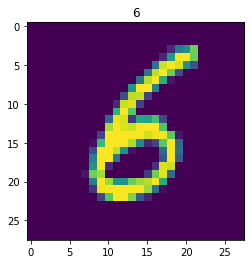

In [ ]:
plt.imshow(np.squeeze(test_images[100]))
plt.title(test_labels[100])